In [1]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
import tensorflow as tf # print(tf.__version__) 2.17.1
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

Found 1 GPUs: Memory growth enabled
Mixed precision enabled
Starting sequential emotion recognition training pipeline
Using MobileNetV2 as base model

1. Loading datasets
Found 8 emotion categories: ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
Found 3161 images in surprise/fer2013
Found 4039 images in surprise/affectnet
Found 4092 images in fear/fer2013
Found 3176 images in fear/affectnet
Found 4951 images in neutral/fer2013
Found 5126 images in neutral/affectnet
Found 4823 images in sad/fer2013
Found 3091 images in sad/affectnet
Found 435 images in disgust/fer2013
Found 2477 images in disgust/affectnet
Found 54 images in contempt/fer2013
Found 2871 images in contempt/affectnet
Found 7199 images in happy/fer2013
Found 5044 images in happy/affectnet
Found 3987 images in anger/fer2013
Found 3218 images in anger/affectnet
Total images: 57744
Found 8 emotion categories: ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
Found 

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using MobileNetV2 base model

4. Computing class weights
AffectNet class weights: {0: 1.128199268738574, 1: 1.2646004098360655, 2: 1.465159069325736, 3: 1.142824074074074, 4: 0.7197632376953581, 5: 0.7081994491622676, 6: 1.1745812714122574, 7: 0.8988129915525779}
FER2013 class weights: {0: 0.899822956624373, 1: 66.29347826086956, 2: 8.241891891891893, 3: 0.8767970097757332, 4: 0.4983657460369341, 5: 0.7246910646387833, 6: 0.7439619419370578, 7: 1.134908820245627}

5. Setting up callbacks

6. STAGE 1: Training on AffectNet
Epoch 1/20
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1624 - loss: 2.2911
Epoch 1: val_accuracy improved from -inf to 0.21048, saving model to model_checkpoints/affectnet_best.weights.h5
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.1626 - loss: 2.2899 - val_accuracy: 0.2105 - val_loss: 1.9879 - learning_rate: 0.0010
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2300 - los

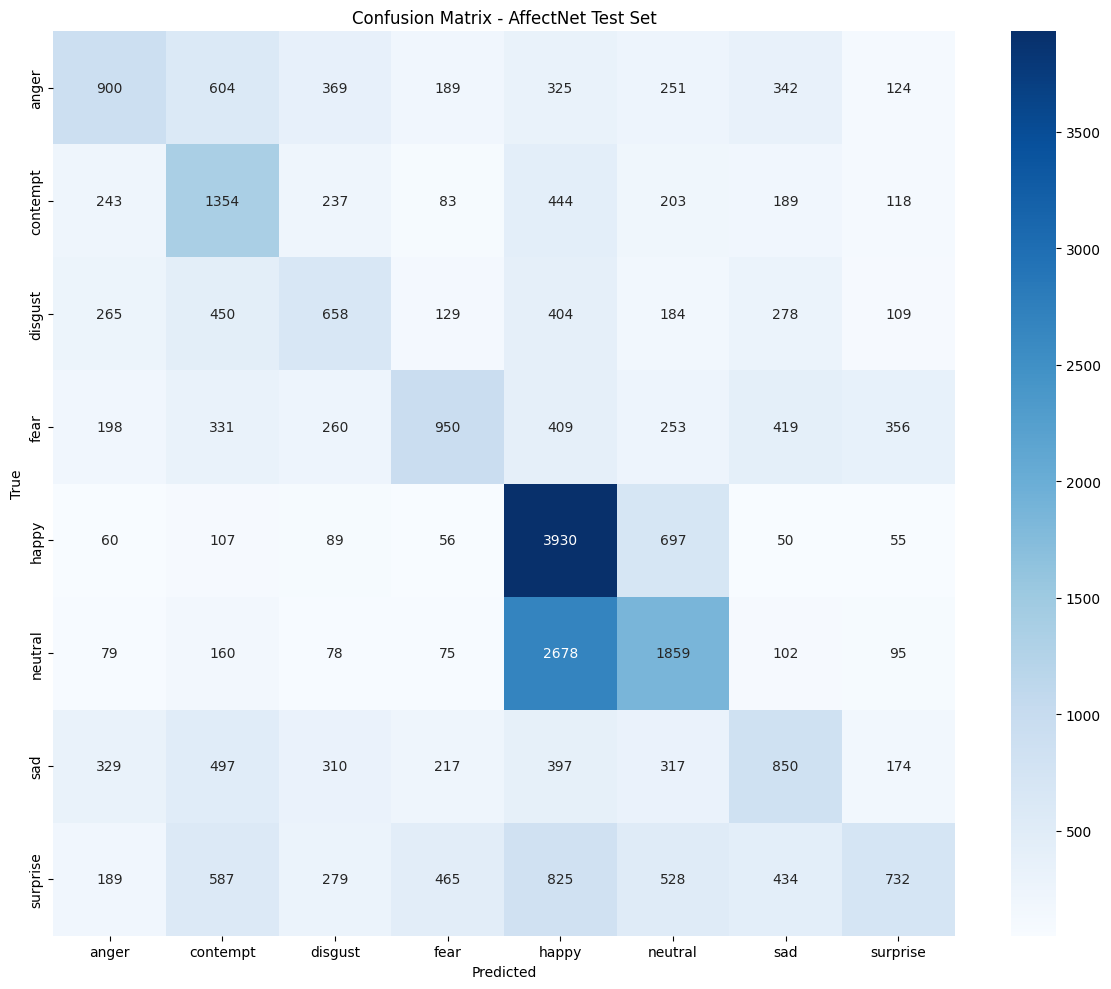

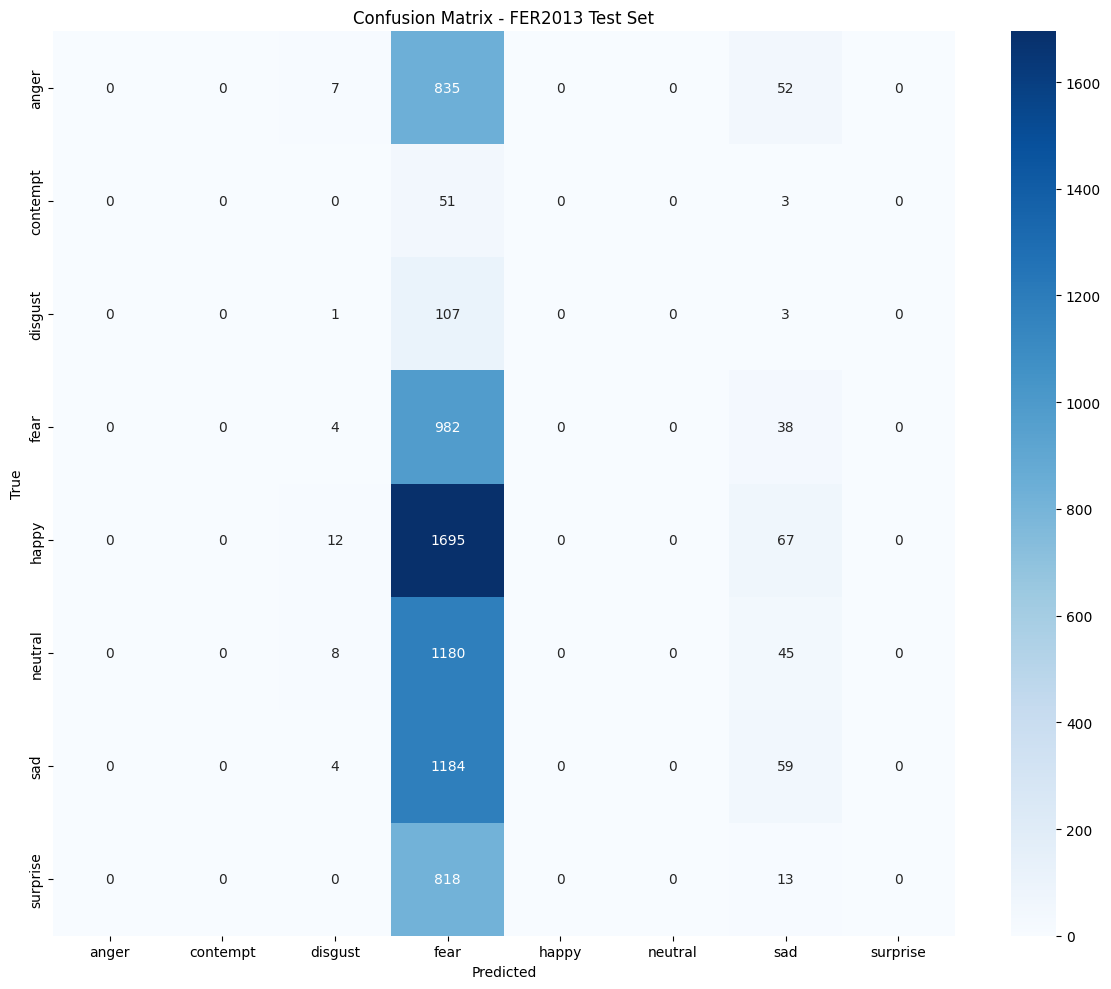

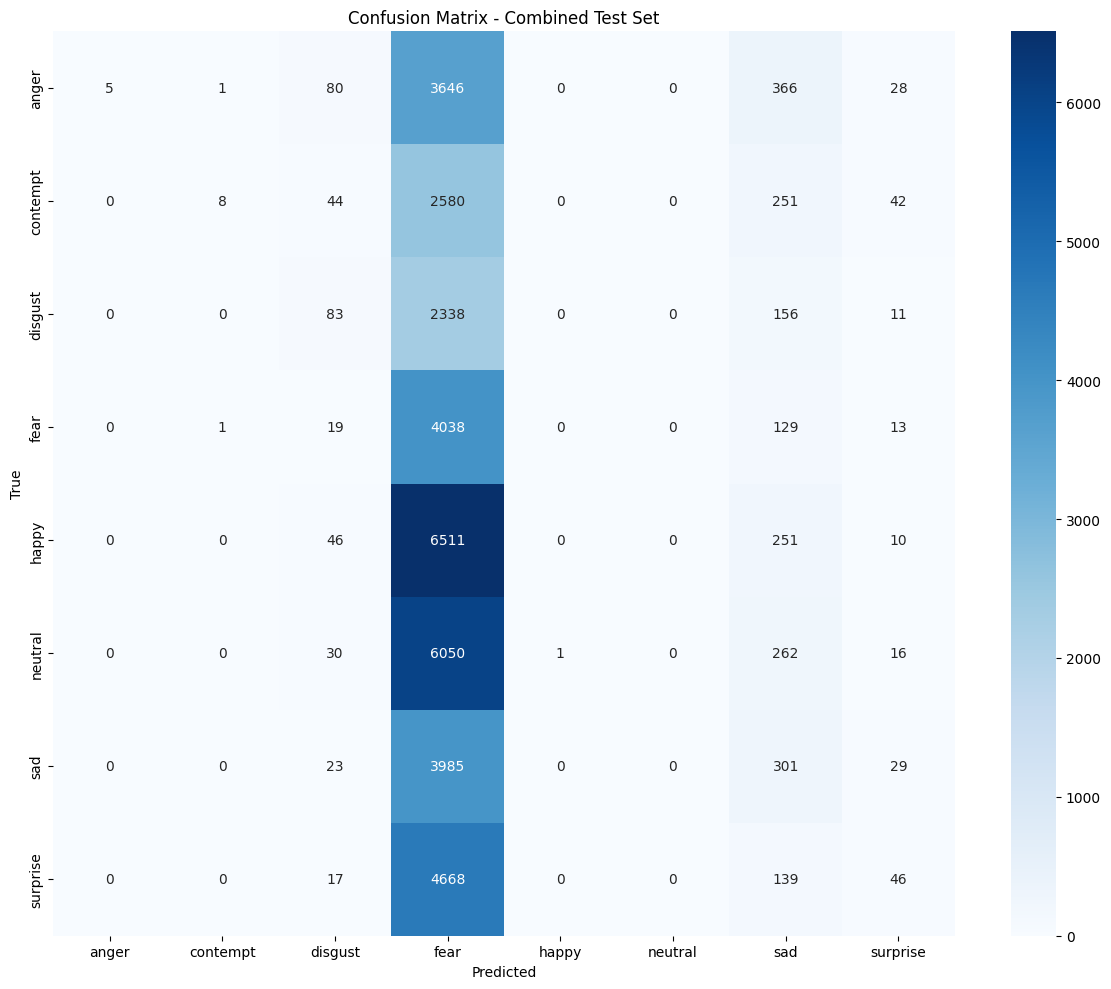

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters
# =============================================================================
IMG_SIZE = 96  # Keep at 96x96 as specified
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs("./model_checkpoints", exist_ok=True)

# =============================================================================
# Custom Label Smoothing Loss
# =============================================================================
def label_smoothing_loss(epsilon=0.1):
    def loss_fn(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = y_true * (1.0 - epsilon) + (epsilon / num_classes)
        return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-7), axis=-1)
    return loss_fn

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# =============================================================================
# Fixed preprocessing function compatible with tf.data graph mode
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Graph-compatible preprocessing function with fixed augmentation.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image - handle errors
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    
    img = decode_image()
    
    # Resize to target size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Normalize pixel values using MobileNet standard preprocessing
    img = tf.cast(img, tf.float32)
    img = img / 127.5 - 1.0  # Scale to [-1, 1]
    
    # Apply fixed augmentation during training that works in graph mode
    if training:
        # Random flip - works in graph mode
        img = tf.image.random_flip_left_right(img)
        
        # Random brightness - fixed amount
        img = tf.image.random_brightness(img, 0.2)
        
        # Random contrast - fixed range
        img = tf.image.random_contrast(img, 0.8, 1.2)
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Fixed dataset creation function
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None):
    """
    Creates a tf.data.Dataset with fixed preprocessing.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether this is for training (includes augmentation)
        dataset_type: Optional filter for specific dataset ('affectnet' or 'fer2013')
        
    Returns:
        tf.data.Dataset and class mapping
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)  # Convert to tensor constant
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Training pipeline
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Important: Repeat dataset for multiple epochs
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Balanced batch sampler
# =============================================================================
def create_balanced_dataset(dataframe, is_training=True, samples_per_class=300):
    """
    Creates a balanced dataset by sampling equal amounts from each class.
    """
    balanced_data = []
    
    # Sample from each class
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        
        # If we don't have enough samples, use all with replacement
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples")
    
    # Create dataset
    return create_dataset(balanced_df, is_training=is_training)

# =============================================================================
# Confusion Matrix Callback
# =============================================================================
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Callback to display confusion matrix during training.
    """
    def __init__(self, validation_data, class_names, log_dir, freq=5):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir

        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            # Calculate and save confusion matrix
            val_steps = 30  # Limit computation
            y_true = []
            y_pred = []
            
            # Get predictions for validation data
            for i, (images, labels) in enumerate(self.validation_data):
                if i >= val_steps:
                    break
                batch_preds = self.model.predict(images, verbose=0)
                y_pred.append(np.argmax(batch_preds, axis=1))
                y_true.append(np.argmax(labels.numpy(), axis=1))
            
            # Flatten the lists
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Calculate per-class accuracy
            class_acc = cm.diagonal() / np.maximum(1, cm.sum(axis=1))
            for i, (name, acc) in enumerate(zip(self.class_names, class_acc)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Save visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - Epoch {epoch+1}')
            plt.tight_layout()
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            plt.close()

# =============================================================================
# Create a MobileNetV2 model for facial emotions
# =============================================================================
def create_emotion_model(num_classes):
    """
    Create a facial emotion recognition model using MobileNetV2.
    
    Args:
        num_classes: Number of emotion classes
        
    Returns:
        Compiled Keras model and base model
    """
    # Input shape
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # Create input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Use MobileNetV2 as base
    base_model = MobileNetV2( #MobileNetV2 MobileNetV3Large
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        alpha=1.0  # Controls model width
    )
    print("Using MobileNetV2 base model")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom head with dropout and batch normalization
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense block
    x = keras.layers.Dense(256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # Second dense block
    x = keras.layers.Dense(128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # Output layer with label smoothing
    outputs = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with label smoothing loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=label_smoothing_loss(epsilon=0.1),
        metrics=['accuracy']
    )
    
    return model, base_model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Sequential Training Pipeline
# =============================================================================
def train_sequential_emotion_model(data_dir):
    """
    Sequentially train on AffectNet then fine-tune on FER2013.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting sequential emotion recognition training pipeline")
    print("Using MobileNetV2 as base model")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets
    print("\n2. Creating data pipelines")
    
    # AffectNet datasets
    affectnet_train_ds, class_indices = create_dataset(
        affectnet_train_df, is_training=True, dataset_type='affectnet')
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, dataset_type='affectnet')
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, dataset_type='affectnet')
    
    # FER2013 datasets
    fer_train_ds, _ = create_dataset(
        fer_train_df, is_training=True, dataset_type='fer2013')
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, dataset_type='fer2013')
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, dataset_type='fer2013')
    
    # Create balanced validation datasets for monitoring
    balanced_affectnet_val_ds, _ = create_balanced_dataset(
        affectnet_val_df, is_training=False)
    balanced_fer_val_ds, _ = create_balanced_dataset(
        fer_val_df, is_training=False)
    
    # 5. Calculate steps
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    # 6. Create model
    print("\n3. Creating model")
    model, base_model = create_emotion_model(num_classes)
    
    # 7. Compute class weights for each dataset
    print("\n4. Computing class weights")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"]),
        y=affectnet_train_df["label"]
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"]), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"]),
        y=fer_train_df["label"]
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"]), fer_weights)}
    
    print("AffectNet class weights:", affectnet_class_weights)
    print("FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks
    print("\n5. Setting up callbacks")
    
    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=LOG_DIR,
        histogram_freq=1,
        update_freq='epoch'
    )
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate scheduler
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # TensorBoard
        tensorboard_callback
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Confusion matrix
        ConfusionMatrixCallback(
            balanced_affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            freq=5
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Confusion matrix
        ConfusionMatrixCallback(
            balanced_fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_training_log.csv', 
            append=True
        )
    ]

    # Create log directories
    ensure_dir(LOG_DIR)
    ensure_dir(LOG_DIR + '/affectnet')
    ensure_dir(LOG_DIR + '/fer2013')
    
    # 9. STAGE 1: Train on AffectNet
    print("\n6. STAGE 1: Training on AffectNet")
    history_affectnet = model.fit(
        affectnet_train_ds,
        epochs=20,
        steps_per_epoch=affectnet_steps_per_epoch,
        validation_data=affectnet_val_ds,
        validation_steps=affectnet_val_steps,
        callbacks=affectnet_callbacks,
        class_weight=affectnet_class_weights,
        verbose=1
    )
    
    # Save AffectNet model
    model.save("affectnet_model.keras")
    print("AffectNet model saved to 'affectnet_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Prepare for FER2013 fine-tuning
    print("\n7. STAGE 2: Fine-tuning on FER2013")
    
    # Unfreeze some layers of the base model for fine-tuning
    # Unfreeze the last 23 layers (last 3 blocks)
    for layer in base_model.layers[-23:]:
        layer.trainable = True
    
    # Recompile with a lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss=label_smoothing_loss(epsilon=0.1),
        metrics=['accuracy']
    )
    
    # 12. Fine-tune on FER2013
    history_fer = model.fit(
        fer_train_ds,
        epochs=15,
        steps_per_epoch=fer_steps_per_epoch,
        validation_data=fer_val_ds,
        validation_steps=fer_val_steps,
        callbacks=fer_callbacks,
        class_weight=fer_class_weights,
        verbose=1
    )
    
    # 13. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 14. Evaluate on combined test set
    # Create a combined test dataset
    combined_test_ds, _ = create_dataset(test_df, is_training=False)
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    combined_metrics = evaluate_model(
        model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 15. Save the final model
    model.save("final_sequential_emotion_model.keras")
    print("Final model saved to 'final_sequential_emotion_model.keras'")
    
    # Return models and metrics
    return model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train model sequentially
    model, metrics = train_sequential_emotion_model(data_dir)
    
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [9]:
# Version 6.0z accuracy 0.1882 class balance deficit 

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

# =============================================================================
# Enable memory growth and mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# =============================================================================
# Key parameters
# =============================================================================
IMG_SIZE = 96  # Keep at 96x96 as requested
BATCH_SIZE = 128  # Moderate batch size
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

# =============================================================================
# Custom Focal Loss Implementation
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss implementation for multi-class classification.
    Focal Loss is designed to address class imbalance by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter. Higher values mean more focus on hard examples.
        alpha: Class weight factor. Higher values give more weight to minority classes.
        
    Returns:
        Focal loss function
    """
    def focal_loss_fn(y_true, y_pred):
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Apply focal weight
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true
        
        # Sum over classes
        focal_loss = K.sum(weight * cross_entropy, axis=-1)
        return K.mean(focal_loss)
    
    return focal_loss_fn

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# Data Augmentation for Minority Classes
# =============================================================================
def augment_minority_classes(df, target_count=5000, minority_classes=None):
    """
    Augment minority classes by duplicating samples to achieve more balanced class distribution.
    
    Args:
        df: DataFrame with image paths and labels
        target_count: Target number of samples per class
        minority_classes: List of specific classes to augment (if None, determined automatically)
        
    Returns:
        Augmented DataFrame
    """
    print("Class distribution before augmentation:")
    print(df['label'].value_counts())
    
    if minority_classes is None:
        # Identify classes with fewer than target_count samples
        class_counts = df['label'].value_counts()
        minority_classes = class_counts[class_counts < target_count].index.tolist()
    
    augmented_data = []
    for cls in minority_classes:
        class_df = df[df['label'] == cls]
        needed = target_count - len(class_df)
        if needed <= 0:
            continue
            
        # Sample with replacement if needed
        print(f"Augmenting class '{cls}': Adding {needed} samples")
        samples = class_df.sample(n=needed, replace=True)
        augmented_data.append(samples)
    
    # Combine augmented data with original
    augmented_df = pd.concat([df] + augmented_data, ignore_index=True)
    
    print("Class distribution after augmentation:")
    print(augmented_df['label'].value_counts())
    
    return augmented_df

# =============================================================================
# Improved preprocessing function
# =============================================================================
def preprocess_image(file_path, label, source):
    """
    Unified preprocessing function with consistent augmentation for both datasets.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode with better error handling
    try:
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
    except tf.errors.InvalidArgumentError:
        try:
            img = tf.image.decode_image(img, channels=1, expand_animations=False)
            img = tf.image.grayscale_to_rgb(img)
        except:
            # Create a blank image if decoding fails
            img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
            print(f"Warning: Failed to decode image at {file_path}")
    
    # Ensure the image has the right shape and type
    img = tf.ensure_shape(img, [None, None, 3])
    
    # Resize to target size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Apply consistent augmentation for both datasets
    if tf.random.uniform([], 0, 1) > 0.5:
        # Standard horizontal flipping
        img = tf.image.random_flip_left_right(img)
        
        # Color augmentations
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        
        # Slight rotation (maximum 15 degrees)
        angle = tf.random.uniform([], -0.25, 0.25)  # in radians
        img = tf.image.rot90(img, k=tf.cast(angle * 2 / 3.14159, tf.int32))
    
    # Convert label to one-hot encoding
    label = tf.one_hot(label, depth=8)  # Assuming 8 emotion classes
    
    return img, label

# =============================================================================
# Fixed dataset creation function
# =============================================================================
def create_dataset(dataframe, is_training=True):
    """
    Create an optimized tf.data.Dataset from a DataFrame with fixed repeating.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether to apply augmentations and shuffling
        
    Returns:
        tf.data.Dataset
    """
    # Convert labels to indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset from file paths, labels, and sources
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        # Training pipeline with augmentation
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Important: Always repeat the dataset for multiple epochs
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Confusion Matrix Callback
# =============================================================================
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Callback to display confusion matrix during training.
    """
    def __init__(self, validation_data, class_names, freq=5):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            # Get a batch of validation data
            validation_steps = 30  # Limit to prevent too much computation
            y_true = []
            y_pred = []
            
            # Get predictions for validation data
            for i, (images, labels) in enumerate(self.validation_data):
                if i >= validation_steps:
                    break
                batch_preds = self.model.predict(images, verbose=0)
                y_pred.append(np.argmax(batch_preds, axis=1))
                y_true.append(np.argmax(labels.numpy(), axis=1))
            
            # Flatten the lists
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Calculate per-class accuracy
            class_acc = cm.diagonal() / cm.sum(axis=1)
            for i, (name, acc) in enumerate(zip(self.class_names, class_acc)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print()

# =============================================================================
# Model Creation
# =============================================================================
def create_simplified_model(num_classes):
    """
    Create a simplified EfficientNetB0 model with a smaller head.
    
    Args:
        num_classes: Number of emotion classes
        
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Load pre-trained model with imagenet weights
    base_model = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_tensor=inputs
    )
    
    # Initially freeze all layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Ensure final layer uses float32 for numerical stability
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy"]
    )
    
    return model, base_model

# =============================================================================
# Main Training Function
# =============================================================================
def train_emotion_recognition_model(data_dir):
    """
    Complete training pipeline incorporating all improvements.
    
    Args:
        data_dir: Path to the dataset directory
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting improved facial emotion recognition training")
    
    # 1. Load and prepare data
    print("\n1. Loading dataset")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    print(f"Original training data: {train_df_full.shape}")
    print(f"Test data: {test_df.shape}")
    
    # 2. Apply class balancing through augmentation
    print("\n2. Balancing class distribution")
    train_df_balanced = augment_minority_classes(train_df_full, target_count=5000)
    
    # 3. Split into train and validation sets
    print("\n3. Creating train/validation split")
    train_df, val_df = train_test_split(
        train_df_balanced, 
        test_size=0.15, 
        stratify=train_df_balanced["label"], 
        random_state=42
    )
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # 4. Create fixed tf.data datasets
    print("\n4. Creating data pipelines")
    train_ds, class_indices = create_dataset(train_df, is_training=True)
    val_ds, _ = create_dataset(val_df, is_training=False)
    test_ds, _ = create_dataset(test_df, is_training=False)
    
    # Get class names in order
    classes = sorted(train_df["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # Calculate steps
    steps_per_epoch = len(train_df) // BATCH_SIZE
    validation_steps = len(val_df) // BATCH_SIZE
    
    # 5. Create model
    print("\n5. Creating simplified model")
    model, base_model = create_simplified_model(num_classes)
    print("Model created")
    
    # 6. Calculate proper class weights
    print("\n6. Computing class weights")
    class_weights_array = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(train_df["label"]), class_weights_array)}
    print("Class weights:", class_weights)
    
    # 7. Setup callbacks
    print("\n7. Setting up training callbacks")
    callbacks = [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_emotion_model.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate scheduler
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # Logging
        tf.keras.callbacks.CSVLogger('training_log.csv', append=True),
        # Confusion matrix
        ConfusionMatrixCallback(val_ds, classes, freq=3)
    ]
    
    # 8. Progressive training approach
    print("\n8. Stage 1: Training only the model head")
    history_stage1 = model.fit(
        train_ds,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # 9. Fine-tune the upper layers
    print("\n9. Stage 2: Fine-tuning upper layers")
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-30:]:
        layer.trainable = True
        
    # Recompile with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy"]
    )
    
    history_stage2 = model.fit(
        train_ds,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # 10. Evaluate on test set
    print("\n10. Final evaluation")
    # Update test steps
    test_steps = len(test_df) // BATCH_SIZE
    
    # Get predictions
    all_predictions = []
    all_labels = []
    
    # Loop through batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= test_steps:
            break
        batch_preds = model.predict(images, verbose=0)
        all_predictions.append(np.argmax(batch_preds, axis=1))
        all_labels.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    
    # Calculate metrics
    test_accuracy = np.mean(all_predictions == all_labels)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_predictions, 
        target_names=classes,
        zero_division=0
    ))
    
    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("\nConfusion Matrix:")
    print(cm)
    
    # 11. Save the final model
    model.save("final_improved_emotion_model.keras")
    print("Model saved to 'final_improved_emotion_model.keras'")
    
    return model, {'accuracy': test_accuracy, 'f1_score': f1}

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train model
    model, metrics = train_emotion_recognition_model(data_dir)
    
    print("Training completed successfully!")
    print(f"Final Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Final F1 Score: {metrics['f1_score']:.4f}")

Starting improved facial emotion recognition training

1. Loading dataset
Original training data: (57744, 3)
Test data: (36274, 3)

2. Balancing class distribution
Class distribution before augmentation:
label
happy       12243
neutral     10077
sad          7914
fear         7268
anger        7205
surprise     7200
contempt     2925
disgust      2912
Name: count, dtype: int64
Augmenting class 'contempt': Adding 2075 samples
Augmenting class 'disgust': Adding 2088 samples
Class distribution after augmentation:
label
happy       12243
neutral     10077
sad          7914
fear         7268
anger        7205
surprise     7200
contempt     5000
disgust      5000
Name: count, dtype: int64

3. Creating train/validation split
Training samples: 52620
Validation samples: 9287
Test samples: 36274

4. Creating data pipelines
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

5. Creating simplified model
Model created

6. Computing class weights
Class weights:

In [8]:
# Version 6.0 accuracy 0.1832 

import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from sklearn.model_selection import train_test_split

# Enable memory growth to prevent TF from allocating all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Memory cleanup callback
class MemoryCleanupCallback(keras.callbacks.Callback):
    """Callback to clear TensorFlow session after each epoch to free memory."""
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()

# =============================================================================
# Define key parameters
# =============================================================================
IMG_SIZE = 96  # Unified image size for both datasets
BATCH_SIZE = 32  # Start with a conservative value
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Try to determine optimal batch size based on available GPU memory
# Start with default batch size
optimal_batch_size = BATCH_SIZE

# Try to detect available GPU memory and adjust batch size
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Get GPU memory info if possible (works on some systems)
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'memory_limit' in gpu_details:
            # Memory in bytes, convert to GB
            gpu_memory_gb = gpu_details['memory_limit'] / (1024**3)
            
            # Simple heuristic: 1GB supports batch size of ~16 for this model
            if gpu_memory_gb > 14:  # High-end GPU (16GB+)
                optimal_batch_size = 128
            elif gpu_memory_gb > 7:  # Mid-range GPU (8GB)
                optimal_batch_size = 64
            else:  # Lower memory GPU
                optimal_batch_size = 32
                
            print(f"Detected {gpu_memory_gb:.1f}GB GPU memory, setting batch size to {optimal_batch_size}")
        else:
            # If we can't detect memory, try a reasonable default for Kaggle
            optimal_batch_size = 64
            print(f"Could not detect GPU memory, using default batch size of {optimal_batch_size}")
except Exception:
    # If anything fails, stay with the default
    print(f"Using default batch size of {optimal_batch_size}")

# Update batch size to optimal value
BATCH_SIZE = optimal_batch_size

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure - Keeping your original function
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# Add data augmentation specifically for underrepresented classes
def augment_minority_classes(df, target_count=5000, minority_classes=None):
    if minority_classes is None:
        # Identify classes with fewer than target_count samples
        class_counts = df['label'].value_counts()
        minority_classes = class_counts[class_counts < target_count].index.tolist()
    
    augmented_data = []
    for cls in minority_classes:
        class_df = df[df['label'] == cls]
        needed = target_count - len(class_df)
        if needed <= 0:
            continue
            
        # Sample with replacement if needed
        samples = class_df.sample(n=needed, replace=True)
        augmented_data.append(samples)
    
    # Combine augmented data with original
    return pd.concat([df] + augmented_data, ignore_index=True)

# Use this before train/val split
train_df_full = augment_minority_classes(train_df_full)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(
    train_df_full, 
    test_size=0.2, 
    stratify=train_df_full["label"], 
    random_state=42
)

# Get class names and create mapping
classes = sorted(train_df_full["label"].unique())
class_indices = {cls: i for i, cls in enumerate(classes)}
num_classes = len(classes)

# =============================================================================
# 4. Create an optimized tf.data pipeline
# =============================================================================
def preprocess_image(file_path, label, source):
    """
    Unified preprocessing function that handles both FER2013 and AffectNet images.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode with error handling
    try:
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
    except:
        img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    
    # Ensure shape and resize
    img = tf.ensure_shape(img, [None, None, 3])
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Apply consistent preprocessing for both datasets
    img = tf.cast(img, tf.float32) / 255.0
    
    # Apply the same augmentation regardless of source
    if tf.random.uniform([], 0, 1) > 0.5:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
    
    # One-hot encode label
    label = tf.one_hot(label, depth=num_classes)
    
    return img, label

def create_dataset(dataframe, is_training=True): # , cache=True
    """
    Create an optimized tf.data.Dataset from a DataFrame.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether to apply augmentations
        cache: Whether to cache the dataset (disable for very large datasets)
        
    Returns:
        tf.data.Dataset
    """
    # Convert labels to indices
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing and batching
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Make sure to repeat the dataset for multiple epochs
    ds = ds.repeat()  # This is crucial
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds

# Create datasets
train_ds = create_dataset(train_df, is_training=True)
val_ds = create_dataset(val_df, is_training=False)
test_ds = create_dataset(test_df, is_training=False)

# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = min(len(val_df) // BATCH_SIZE, 100)  # Limit validation steps

# Sanity check - inspect a batch to verify the dataset pipeline
def inspect_dataset(dataset, name):
    """Inspect a dataset to verify it's created correctly."""
    print(f"\nInspecting {name} dataset:")
    
    try:
        # Get one batch
        for images, labels in dataset.take(1):
            print(f"  Batch shape: {images.shape}")
            print(f"  Labels shape: {labels.shape}")
            print(f"  Data type: {images.dtype}")
            print(f"  Min/Max values: {tf.reduce_min(images).numpy():.4f}/{tf.reduce_max(images).numpy():.4f}")
            
            # Check for NaNs
            has_nans = tf.math.reduce_any(tf.math.is_nan(images))
            print(f"  Contains NaNs: {has_nans.numpy()}")
            
            # Verify one-hot labels
            label_sums = tf.reduce_sum(labels, axis=1)
            all_ones = tf.reduce_all(tf.equal(label_sums, 1))
            print(f"  Labels are valid one-hot: {all_ones.numpy()}")
            
            # All checks passed
            print(f"  ✅ {name} dataset looks good!")
            return True
    except Exception as e:
        print(f"  ❌ Error inspecting {name} dataset: {str(e)}")
        return False

# Run sanity checks
train_ok = inspect_dataset(train_ds, "Training")
val_ok = inspect_dataset(val_ds, "Validation")
test_ok = inspect_dataset(test_ds, "Test")

# Abort if datasets are not created correctly
if not (train_ok and val_ok and test_ok):
    print("\n⚠️ Dataset sanity check failed! Please check the error messages above.")
    print("You can continue but training might fail.")

# =============================================================================
# 5. Compute Class Weights to handle imbalance
# =============================================================================
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights = {class_indices[label]: weight for label, weight in 
                 zip(np.unique(train_df["label"]), class_weights_array)}

# =============================================================================
# 6. Model Architecture with Optimized Transfer Learning
# =============================================================================
def create_model():
    """
    Create an EfficientNetB0 model with frozen layers and custom top.
    
    Returns:
        Compiled Keras model
    """
    # Create input layer with the correct shape
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Load pre-trained model with imagenet weights
    base_model = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_tensor=input_tensor
    )
    
    # Freeze the first 70% of layers
    freeze_until = int(len(base_model.layers) * 0.7)
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    
    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    # Ensure final layer uses float32 for numerical stability with softmax
    output = Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    # Create model
    model = Model(inputs=input_tensor, outputs=output)
    
    # Compile with Adam optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# =============================================================================
# 7. Learning Rate Scheduler and Callbacks
# =============================================================================
def cosine_decay_schedule(epoch, lr):
    """
    Cosine decay learning rate schedule.
    
    Args:
        epoch: Current epoch
        lr: Current learning rate
        
    Returns:
        New learning rate
    """
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / EPOCHS)) / 2

# Create callbacks
callbacks = [
    # Save checkpoints (using proper file extension for weights)
    keras.callbacks.ModelCheckpoint(
        'best_model.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,  # Save only weights to reduce I/O
        verbose=1
    ),
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Learning rate scheduling
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # Log training metrics
    keras.callbacks.CSVLogger('training_log.csv', append=True),
    # Memory cleanup after each epoch
    MemoryCleanupCallback()

]

# =============================================================================
# 8. Training
# =============================================================================
def train_model(custom_callbacks=None, existing_model=None, quick_test=False):
    """
    Train the model with the optimized pipeline.
    
    Args:
        custom_callbacks: Additional callbacks to use during training
        existing_model: Continue training this model if provided
        quick_test: Whether this is a quick test run
        
    Returns:
        Trained model and history
    """
    # Create new model or use existing one
    if existing_model is None:
        model = create_model()
        # Print model summary
        model.summary()
    else:
        model = existing_model
        print("Continuing training with existing model")
    
    # Use custom callbacks if provided, otherwise use default callbacks
    training_callbacks = custom_callbacks if custom_callbacks else callbacks
    
    # Adjust epochs and steps for quick test
    current_epochs = 2 if quick_test else EPOCHS
    current_steps = min(20, steps_per_epoch) if quick_test else steps_per_epoch
    current_val_steps = min(10, validation_steps) if quick_test else validation_steps
    
    if quick_test:
        print(f"Quick test mode: {current_epochs} epochs, {current_steps} steps/epoch")
    
    # Train model
    history = model.fit(
        train_ds,
        epochs=current_epochs,
        steps_per_epoch=current_steps,
        validation_data=val_ds,
        validation_steps=current_val_steps,
        callbacks=training_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# =============================================================================
# 9. LR Finder - Fixed version with termination condition
# =============================================================================
class LRFinder(keras.callbacks.Callback):
    """
    Learning rate finder callback.
    
    This callback helps find the optimal learning rate by exponentially
    increasing the learning rate during training and recording the loss.
    """
    def __init__(self, min_lr=1e-7, max_lr=1e-2, steps=100, max_batches=1000):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.max_batches = max_batches  # Safety limit
        self.lrs = []
        self.losses = []
        self.batch_counter = 0
        
    def on_train_begin(self, logs=None):
        # Store original learning rate
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        # Set initial learning rate to minimum
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_train_batch_end(self, batch, logs=None):
        # Get current learning rate
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        
        # Calculate new learning rate
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        
        # Increment counter and check for termination
        self.batch_counter += 1
        if batch >= self.steps or self.batch_counter >= self.max_batches:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        # Restore original learning rate
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)
        
    def plot_lr_finder(self):
        """Plot the learning rate finder results."""
        try:
            import matplotlib.pyplot as plt
            
            plt.figure(figsize=(10, 6))
            plt.plot(self.lrs, self.losses)
            plt.xscale('log')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            plt.title('Learning Rate Finder')
            plt.savefig('lr_finder_results.png')
        except ImportError:
            print("Matplotlib not available for plotting. Saving results to CSV instead.")
            import csv
            with open('lr_finder_results.csv', 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['learning_rate', 'loss'])
                for lr, loss in zip(self.lrs, self.losses):
                    writer.writerow([lr, loss])

# =============================================================================
# 10. Training with LR Finder
# =============================================================================
def find_optimal_lr():
    """
    Find the optimal learning rate using the LR Finder.
    
    Returns:
        Suggested learning rate
    """
    # Create model
    model = create_model()
    
    # Create LR Finder callback
    lr_finder = LRFinder(min_lr=1e-7, max_lr=1e-2, steps=100, max_batches=100)
    
    # Fit model for a few batches to find optimal LR
    model.fit(
        train_ds,
        epochs=1,
        steps_per_epoch=100,
        callbacks=[lr_finder],
        verbose=1
    )
    
    # Plot results
    lr_finder.plot_lr_finder()
    
    # Find the learning rate with the steepest negative gradient
    losses = lr_finder.losses
    lrs = lr_finder.lrs
    
    # Smoothing
    smooth_losses = []
    for i in range(len(losses)):
        if i < 2 or i >= len(losses) - 2:
            smooth_losses.append(losses[i])
        else:
            smooth_losses.append(sum(losses[i-2:i+3]) / 5)
    
    # Calculate gradients
    gradients = []
    for i in range(1, len(smooth_losses)):
        gradients.append((smooth_losses[i] - smooth_losses[i-1]) / (lrs[i] - lrs[i-1]))
    
    # Find the point with the steepest negative gradient
    steepest_idx = np.argmin(gradients)
    optimal_lr = lrs[steepest_idx + 1] / 10  # Division by 10 is common practice
    
    print(f"Suggested learning rate: {optimal_lr:.2e}")
    return optimal_lr

# =============================================================================
# 11. Evaluation
# =============================================================================
def evaluate_model(model):
    """
    Evaluate the model on the test set.
    
    Args:
        model: Trained Keras model
        
    Returns:
        Evaluation metrics
    """
    # Evaluate model
    loss, accuracy = model.evaluate(test_ds)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Get predictions
    predictions = np.argmax(model.predict(test_ds), axis=-1)
    
    # Get true labels
    true_labels = []
    for _, y in test_ds.unbatch():
        true_labels.append(np.argmax(y.numpy()))
    true_labels = np.array(true_labels)
    
    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f"\nWeighted F1-Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        true_labels, 
        predictions, 
        target_names=classes,
        zero_division=0
    ))
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# =============================================================================
# 12. Fine-tune Model
# =============================================================================
def fine_tune_model(model, epochs=5, custom_callbacks=None, quick_test=False):
    """
    Fine-tune the model by unfreezing all layers.
    
    Args:
        model: Trained model
        epochs: Number of fine-tuning epochs
        custom_callbacks: Additional callbacks to use during fine-tuning
        quick_test: Whether this is a quick test run
        
    Returns:
        Fine-tuned model and history
    """
    # Unfreeze all layers
    for layer in model.layers:
        layer.trainable = True
    
    # Recompile with a lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Use custom callbacks if provided, otherwise use default callbacks
    training_callbacks = custom_callbacks if custom_callbacks else callbacks
    
    # Adjust epochs and steps for quick test
    current_epochs = 2 if quick_test else epochs
    current_steps = min(20, steps_per_epoch) if quick_test else steps_per_epoch
    current_val_steps = min(10, validation_steps) if quick_test else validation_steps
    
    if quick_test:
        print(f"Quick fine-tuning: {current_epochs} epochs, {current_steps} steps/epoch")
    
    # Fine-tune
    history = model.fit(
        train_ds,
        epochs=current_epochs,
        steps_per_epoch=current_steps,
        validation_data=val_ds,
        validation_steps=current_val_steps,
        callbacks=training_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# =============================================================================
# 13. Performance Monitoring
# =============================================================================
class PerformanceMonitor(keras.callbacks.Callback):
    """
    Monitor and log training performance metrics like time per step.
    """
    def __init__(self):
        super(PerformanceMonitor, self).__init__()
        self.batch_times = []
        self.epoch_start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.batch_start_time = time.time()
        self.batch_times = []
        
    def on_batch_end(self, batch, logs=None):
        batch_time = time.time() - self.batch_start_time
        self.batch_times.append(batch_time)
        self.batch_start_time = time.time()
        
        # Log every 50 batches
        if batch % 50 == 0:
            avg_time = sum(self.batch_times[-50:]) / min(50, len(self.batch_times))
            print(f"\nBatch {batch} - Avg time: {avg_time*1000:.2f}ms/step")
            
            # Try to get GPU memory info if available
            try:
                import subprocess
                gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader']).decode('utf-8')
                print(f"GPU Memory: {gpu_info.strip()}")
            except:
                pass
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        avg_batch_time = sum(self.batch_times) / len(self.batch_times)
        print(f"\nEpoch {epoch+1} completed in {epoch_time:.2f}s - Avg: {avg_batch_time*1000:.2f}ms/step")

# =============================================================================
# 14. Main training loop
# =============================================================================
def main():
    """Main function to run the training pipeline."""
    # Print TF and GPU info
    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
    
    # Print dataset info
    print(f"Train samples: {len(train_df)} ({len(train_df[train_df['source'] == 'fer2013'])} FER, {len(train_df[train_df['source'] == 'affectnet'])} AffectNet)")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Classes: {classes}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Set to True to run a quick test first, or False for full training
    run_quick_test = True  # Change this manually if needed
    
    if run_quick_test:
        print("\nRunning quick test (2 epochs with limited steps)...")
        # Define variables for testing
        quick_test_epochs = 2
        quick_test_steps = min(20, steps_per_epoch)
        print(f"Quick test settings: {quick_test_epochs} epochs, {quick_test_steps} steps per epoch")
    
    # Create performance monitor
    perf_monitor = PerformanceMonitor()
    
    # Add performance monitor to callbacks
    training_callbacks = callbacks + [perf_monitor]
    
    try:
        # Find optimal learning rate (optional)
        # optimal_lr = find_optimal_lr()
        
        # Train model (with quick test if selected)
        print("\n=== Starting initial training phase ===")
        
        if run_quick_test:
            # Run a quick test first
            print("\n=== Running quick test ===")
            model, quick_history = train_model(
                custom_callbacks=training_callbacks,
                quick_test=True
            )
            
            # After successful quick test, continue with full training
            print("\n=== Quick test complete, continuing with full training ===")
            model, history = train_model(
                custom_callbacks=training_callbacks,
                existing_model=model
            )
        else:
            # Full training from the start
            model, history = train_model(custom_callbacks=training_callbacks)
            
            # Evaluate model after initial training
            print("\n=== Evaluating after initial training ===")
            metrics = evaluate_model(model)
            
            # Fine-tune model (with quick test mode if enabled)
            print("\n=== Starting fine-tuning phase ===")
            model, ft_history = fine_tune_model(
                model, 
                epochs=5, 
                custom_callbacks=training_callbacks,
                quick_test=run_quick_test
            )
        
        # Final evaluation
        print("\n=== Final evaluation ===")
        final_metrics = evaluate_model(model)
        
        # Save the final model
        model.save("final_emotion_model.keras")
        
        print("\nTraining complete! Final model saved as 'final_emotion_model.keras'")
        
    except Exception as e:
        import traceback
        print("\n*** ERROR DURING TRAINING ***")
        print(traceback.format_exc())
        print("\nDetailed error:", str(e))
        
        # Try to save the model if it exists
        try:
            if 'model' in locals():
                print("Attempting to save the model before exiting...")
                model.save("emergency_save_model.keras")
                print("Model saved as emergency_save_model.keras")
        except Exception as save_error:
            print(f"Failed to save model: {save_error}")
    
if __name__ == "__main__":
    import time
    start_time = time.time()
    main()
    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time/60:.2f} minutes")

Could not detect GPU memory, using default batch size of 64
Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)

Inspecting Training dataset:
  Batch shape: (64, 96, 96, 3)
  Labels shape: (64, 8)
  Data type: <dtype: 'float32'>
  Min/Max values: -0.2049/1.2440
  Contains NaNs: False
  Labels are valid one-hot: True
  ✅ Training dataset looks good!

Inspecting Validation dataset:
  Batch shape: (64, 96, 96, 3)
  Labels shape: (64, 8)
  Data type: <dtype: 'float32'>
  Min/Max values: -0.2408/1.2506
  Contains NaNs: False
  Labels are valid one-hot: True
  ✅ Validation dataset looks good!

Inspecting Test dataset:
  Batch shape: (64, 96, 96, 3)
  Labels shape: (64, 8)
  Data type: <dtype: 'float32'>
  Min/Max values: -0.2448/1.2200
  Contains NaNs: False
  Labels are valid one-hot: True
  ✅ Test dataset looks good!
TensorFlow version: 2.17.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Train samples: 49525 (23351 FER, 26174 AffectNet)
V

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 96, 96, 3)      │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 96, 96, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 4,379,563 (16.71 MB)

 Trainable params: 3,409,124 (13.00 MB)

 Non-trainable params: 970,439 (3.70 MB)

Quick test mode: 2 epochs, 20 steps/epoch
Epoch 1/2

Batch 0 - Avg time: 40092.85ms/step
GPU Memory: 2353 MiB
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1122 - loss: 6.5137
Epoch 1: val_accuracy improved from -inf to 0.15937, saving model to best_model.weights.h5

Epoch 1 completed in 47.50s - Avg: 2033.28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 389ms/step - accuracy: 0.1126 - loss: 6.5079 - val_accuracy: 0.1594 - val_loss: 6.2758 - learning_rate: 1.0000e-04
Epoch 2/2

Batch 0 - Avg time: 2609.65ms/step
GPU Memory: 2353 MiB
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1281 - loss: 6.3556
Epoch 2: val_accuracy improved from 0.15937 to 0.17969, saving model to best_model.weights.h5

Epoch 2 completed in 5.31s - Avg: 158.28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.1277 - loss: 6.3541 - val_accuracy: 0.1797 - val_loss: 6.1508 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.

=== Quick test complete, continuing wit

KeyboardInterrupt: 

Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)


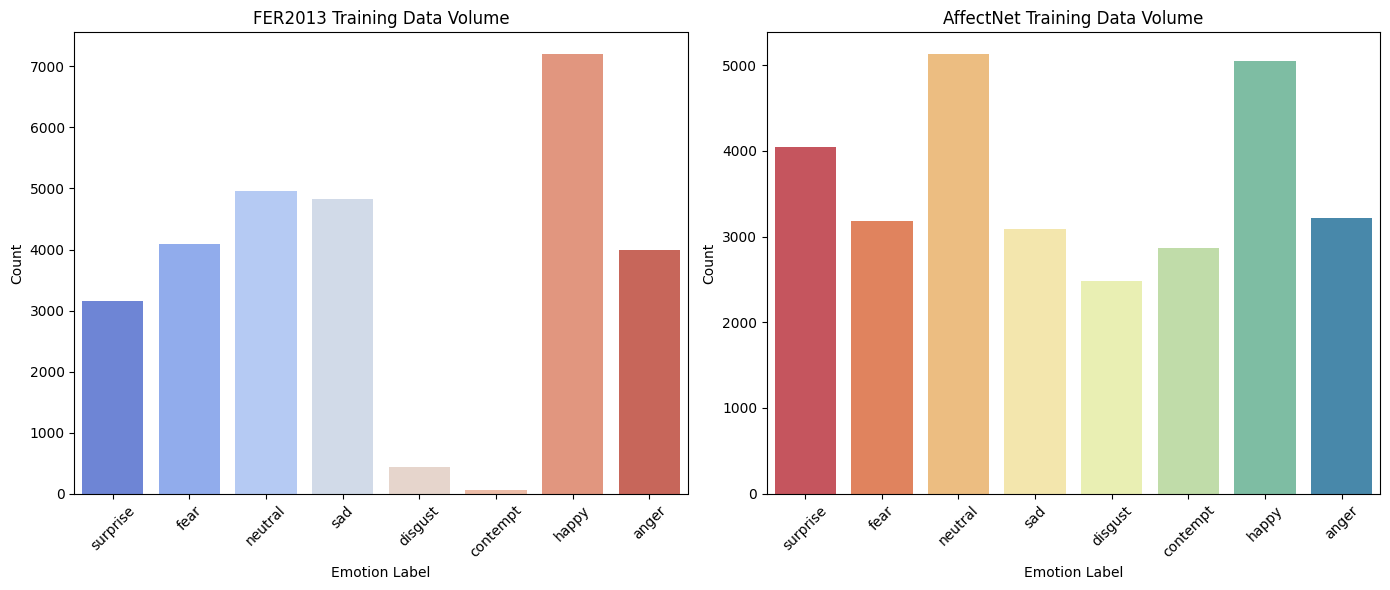

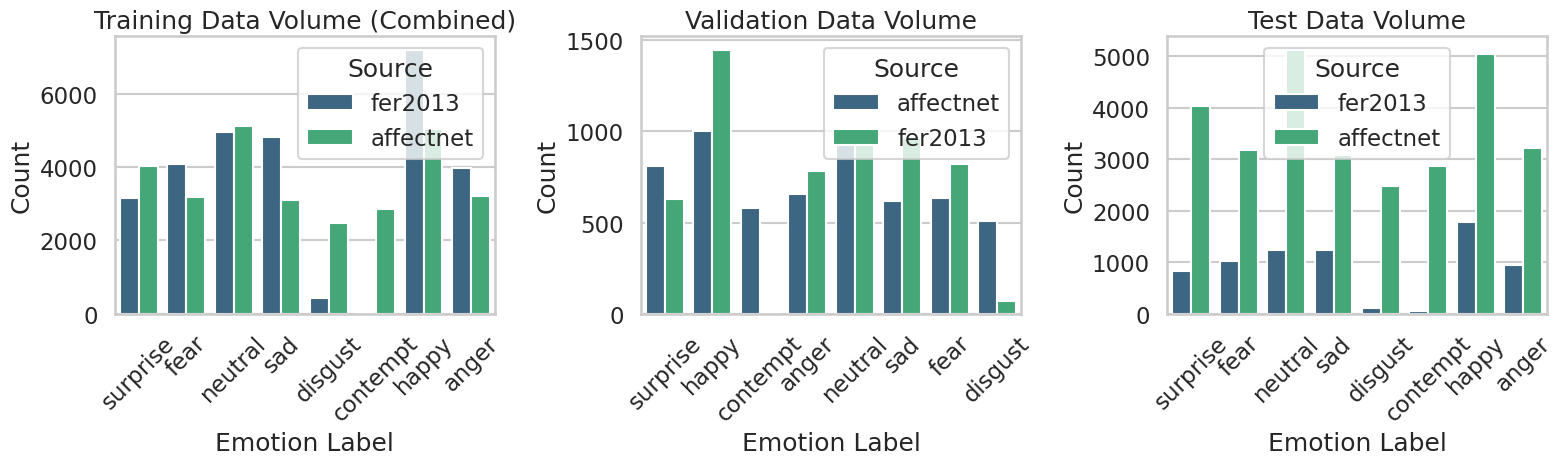

Found 46195 validated image filenames belonging to 8 classes.
Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Train samples: 46195
FER samples: 22986
AffectNet samples: 23209
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 11549 validated image filenames belonging to 8 classes.
Starting simplified training...
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.1810 - loss: 0.3842 - val_accuracy: 0.1406 - val_loss: 0.3824
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.2334 - loss: 0.3631 - val_accuracy: 0.2281 - val_loss: 0.3550
Simplified training completed!
Found 36274 validated image filenames belonging to 8 classes.


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [3]:
# Version 5.0 orginal working code slightly

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import logging
logging.basicConfig(level=logging.INFO)
tf.get_logger().setLevel(logging.INFO)

import gc
class MemoryCleanup(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()


# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64
epochs = 30

# =============================================================================
# Learning Rate Finder Callback (Fixed)
# =============================================================================
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps=100):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        
    def on_train_begin(self, logs=None):
        # Use optimizer.learning_rate (compatible with LossScaleOptimizer)
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        if batch >= self.steps:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# Additional Plots: Separate by Source (Optional)
fer_df = train_df_full[train_df_full["source"] == "fer2013"]
aff_df = train_df_full[train_df_full["source"] == "affectnet"]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=fer_df, palette="coolwarm")
plt.title("FER2013 Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=aff_df, palette="Spectral")
plt.title("AffectNet Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# X. Visualization Code for DataFrames
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for a beautiful design.
sns.set(style="whitegrid", context="talk", palette="viridis")

# Plot 1: Training Data (Combined by Source)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.countplot(x="label", hue="source", data=train_df_full, palette="viridis")
plt.title("Training Data Volume (Combined)")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Source")

# Plot 2: Validation Data (Combined by Source)
plt.subplot(1, 3, 2)
if "source" in val_df.columns:
    sns.countplot(x="label", hue="source", data=val_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=val_df, palette="viridis")
plt.title("Validation Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plot 3: Test Data
plt.subplot(1, 3, 3)
if "source" in test_df.columns:
    sns.countplot(x="label", hue="source", data=test_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=test_df, palette="viridis")
plt.title("Test Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. Source-Specific Augmentation Functions
# =============================================================================
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# =============================================================================
# 5. Create Separate Generators for FER2013 and AffectNet
# =============================================================================
# Create a simpler, more robust training loop
# First, simplify your dataset creation

classes = sorted(train_df_full["label"].unique())

train_datagen = ImageDataGenerator(
    rescale=1./255
    #preprocessing_function=lambda x: np.repeat(x, 3, axis=-1) if x.shape[-1] == 1 else x
)

simple_train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",  # Use rgb for all images to simplify
    class_mode="categorical",
    classes=classes,
    batch_size=16,  # Reduced batch size
    shuffle=True
)

# Split the training DataFrame by source
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

# For FER2013: load as grayscale with gentle augmentation.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=classes,
    batch_size=64,
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentation.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 30,  # Reduced from 40
    "brightness_range": [0.7, 1.3],  # Reduced from [0.5, 1.5]
    "zoom_range": 0.1  # Reduced from 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    classes=classes,
    batch_size=64,
    shuffle=True
)

#######################################################################################
# If your images are grayscale and need to be converted to RGB, add this:
def convert_grayscale_to_rgb(batch_x, batch_y):
    # If the last dimension is 1, repeat it 3 times
    if batch_x.shape[-1] == 1:
        batch_x = np.repeat(batch_x, 3, axis=-1)
    return batch_x, batch_y

# Create a wrapper for your generator
def rgb_generator_wrapper(gen):
    for batch_x, batch_y in gen:
        yield convert_grayscale_to_rgb(batch_x, batch_y)

# Use the wrapped generator
rgb_train_gen = rgb_generator_wrapper(simple_train_gen)

#######################################################################################

# Calculate steps for each dataset.
steps_fer = math.ceil(len(fer_train_df) / 64)  # 22986/32=719
steps_aff = math.ceil(len(aff_train_df) / 64)  # 23209/32=726
steps_per_epoch = steps_fer + steps_aff        # 1445

#steps_fer = math.ceil(fer_train_df.shape[0] / 32)
#steps_aff = math.ceil(aff_train_df.shape[0] / 32)
#steps_per_epoch = steps_fer + steps_aff
#print(f"Steps per epoch: {steps_per_epoch}")

# After splitting in Section 3:
print(f"Train samples: {len(train_df)}")  # Should be ~36k (80% of 46k)
print(f"FER samples: {len(fer_train_df)}")  # ~18k (80% of 23k)
print(f"AffectNet samples: {len(aff_train_df)}")  # ~18k (80% of 23k)

# =============================================================================
# 6. Enhanced Upscaling for FER2013: Bicubic interpolation and channel replication.
# =============================================================================
def preprocess_fer_batch(batch):
    # Input: (batch_size, H, W, 1)
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    return tf.repeat(upscaled, repeats=3, axis=-1)  # Now shape: (batch_size, img_size, img_size, 3)

# Wrap the FER generator into a tf.data.Dataset.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, simply convert batches to tensors.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# =============================================================================
# 7. Combine the Two Datasets and Optimize Pipeline
# =============================================================================
# Both ds_fer and ds_aff already yield batches, so do NOT apply an additional .batch() here.
combined_ds = ds_fer.concatenate(ds_aff)
combined_ds = combined_ds.shuffle(buffer_size=200).prefetch(2)

#combined_ds = ds_fer.concatenate(ds_aff)
#combined_ds = combined_ds.shuffle(500).prefetch(tf.data.AUTOTUNE)

# =============================================================================
# 8. Compute Class Weights
# =============================================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
label_to_index = fer_gen.class_indices  # Assumes consistency across sources.
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# =============================================================================
# 9. Model Architecture
# =============================================================================
# (Optional) Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

#from tensorflow.keras.applications import MobileNetV2
#base_model = MobileNetV2(include_top=False, weights="imagenet", 
#                        input_tensor=input_tensor,
#                        input_shape=(img_size, img_size, 3))

input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

freeze_until = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax", dtype="float32")(x)
model = Model(inputs=input_tensor, outputs=output)

# =============================================================================
# 10. Focal Loss (Optional)
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # Or use "categorical_crossentropy"

simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_function, #'categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 11. Training Configuration & Callbacks
# =============================================================================

def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

# Minimal callback list
minimal_callbacks = [
    tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', save_best_only=True),
    tf.keras.callbacks.CSVLogger('simple_training_log.csv', append=True)
]

# Create a validation dataset from val_df using a similar pipeline for FER images.
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_generator:
        images, labels = batch
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

start_time = time.time()
print("Starting simplified training...")
simple_history = simple_model.fit(
    simple_train_gen,
    epochs=2,
    steps_per_epoch=50,  # Drastically reduced to test
    validation_data=ds_val, #val_generator,
    validation_steps=10,  # Also reduced
    callbacks=minimal_callbacks
)
print("Simplified training completed!")

# Save the trained model
model.save("final_emotion_model.keras")

# =============================================================================
# 12. Evaluation & Visualization on Test Data
# =============================================================================
# First, create a clean test generator without any preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",  # Load as grayscale first
    class_mode="categorical",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

# Then create a simpler wrapper that ensures exactly 3 channels
def test_wrapper():
    for batch_x, batch_y in test_generator:
        # Convert grayscale to RGB once - explicitly tracking shape
        if batch_x.shape[-1] == 1:
            # This creates exactly 3 channels
            batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)
            yield batch_x_rgb, batch_y
        else:
            yield batch_x, batch_y

# Create the dataset with proper output signature
test_ds = tf.data.Dataset.from_generator(
    test_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).batch(batch_size).prefetch(2)

# Now evaluate with this clean dataset
loss, accuracy = simple_model.evaluate(test_ds)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(simple_model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# =============================================================================
# 13. Testing Saved Model on Individual Test Images
# =============================================================================
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load as grayscale then convert to RGB.
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net")

print("Path to dataset files:", path)

In [ ]:
fer_dirs = glob.glob(os.path.join(train_dir, "*", "fer2013"))
aff_dirs = glob.glob(os.path.join(train_dir, "*", "affectnet"))
print("FER directories found:", glob.glob(os.path.join(train_dir, "*", "fer2013")))
print("AffectNet directories found:", glob.glob(os.path.join(train_dir, "*", "affectnet")))


Train DataFrame shape: (57744, 3)
Test DataFrame shape: (36274, 3)
Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 22986 validated image filenames belonging to 8 classes.
Found 23209 validated image filenames belonging to 8 classes.
Found 5716 validated image filenames belonging to 8 classes.
Found 5833 validated image filenames belonging to 8 classes.
Found 7232 validated image filenames belonging to 8 classes.
Found 29042 validated image filenames belonging to 8 classes.
Class weights: {0: 1.0017999653018737, 1: 2.467681623931624, 2: 2.478272532188841, 3: 0.9931845545235638, 4: 0.5895829079027977, 5: 0.7162459687422476, 6: 0.9120794503238036, 7: 1.0024956597222223}
Using mixed precision
Starting main function
Model type: efficientnet
Created efficientnet model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ cast_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 96, 96, 3)      │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 4,385,707 (16.73 MB)

 Trainable params: 4,173,412 (15.92 MB)

 Non-trainable params: 212,295 (829.28 KB)

Steps per epoch: 722
Validation steps: 181
Training error: Unrecognized data type: x=<__main__.CombinedGenerator object at 0x7b4aaf048580> (of type <class '__main__.CombinedGenerator'>)
Error in main function: 'NoneType' object has no attribute 'history'


Traceback (most recent call last):
  File "<ipython-input-4-4bb4cee26711>", line 643, in main
    plot_training_history(history)
  File "<ipython-input-4-4bb4cee26711>", line 544, in plot_training_history
    plt.plot(history.history['accuracy'], label='Training')
AttributeError: 'NoneType' object has no attribute 'history'


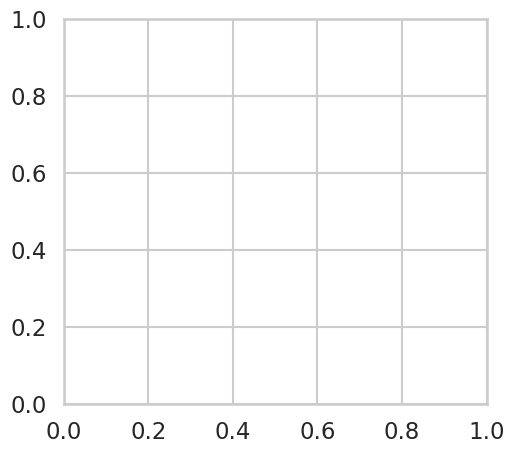

In [4]:
# NEW Experimental

import tensorflow.keras.backend as K
import os
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC, Precision, Recall

# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64       # Smaller batch size to avoid memory issues
epochs = 20           # Increase epochs, we'll use early stopping
model_type = "efficientnet"  # Options: "efficientnet", "mobilenet", "ensemble"

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
# Adjust this path to your actual data directory
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# 4. Data Visualization (Optional)
# =============================================================================
def plot_data_distribution():
    # Plot distribution of emotions by source
    plt.figure(figsize=(16, 6))
    
    # Combined
    plt.subplot(1, 3, 1)
    sns.countplot(x="label", data=train_df_full, palette="viridis")
    plt.title("Full Dataset Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # FER2013
    plt.subplot(1, 3, 2)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "fer2013"], palette="coolwarm")
    plt.title("FER2013 Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # AffectNet
    plt.subplot(1, 3, 3)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "affectnet"], palette="Spectral")
    plt.title("AffectNet Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize data distribution
# plot_data_distribution()

# =============================================================================
# 5. Optimized Data Generators
# =============================================================================
# Get emotion classes
classes = sorted(train_df_full["label"].unique())
print(f"Classes: {classes}")

# Define preprocessing functions
def preprocess_fer(img):
    """Convert grayscale to RGB and resize to target size"""
    # Convert to 3 channels by repeating the grayscale channel
    img = tf.image.grayscale_to_rgb(img)
    # Resize to target size
    img = tf.image.resize(img, [img_size, img_size], method='bicubic')
    return img / 255.0  # Normalize

def preprocess_affectnet(img):
    """Resize RGB image to target size"""
    img = tf.image.resize(img, [img_size, img_size])
    return img / 255.0  # Normalize

# Create training data generators
def create_generators():
    # Common augmentation parameters
    common_aug = {
        'horizontal_flip': True,
        'rotation_range': 20,
        'fill_mode': 'nearest'
    }
    
    # For FER2013 (grayscale)
    fer_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        **common_aug
    )
    
    fer_train_gen = fer_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # For AffectNet (RGB)
    aff_datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        **common_aug
    )
    
    aff_train_gen = aff_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Validation generators - no augmentation
    val_datagen = ImageDataGenerator()
    
    fer_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen

# Create test generator
def create_test_generator():
    test_datagen = ImageDataGenerator()
    
    # Split test data by source
    fer_test_df = test_df[test_df["source"] == "fer2013"]
    aff_test_df = test_df[test_df["source"] == "affectnet"]
    
    fer_test_gen = test_datagen.flow_from_dataframe(
        dataframe=fer_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_test_gen = test_datagen.flow_from_dataframe(
        dataframe=aff_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_test_gen, aff_test_gen

fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen = create_generators()
fer_test_gen, aff_test_gen = create_test_generator()

# =============================================================================
# 6. Custom Data Generator that combines both sources
# =============================================================================
class CombinedGenerator:
    def __init__(self, fer_gen, aff_gen, batch_size=32):
        self.fer_gen = fer_gen
        self.aff_gen = aff_gen
        self.batch_size = batch_size
        self.n_classes = len(classes)
        self.fer_samples = len(fer_gen.filenames)
        self.aff_samples = len(aff_gen.filenames)
        self.total_samples = self.fer_samples + self.aff_samples
        
    def __len__(self):
        return (self.total_samples + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        self.fer_iter = iter(self.fer_gen)
        self.aff_iter = iter(self.aff_gen)
        return self
    
    def __next__(self):
        # Randomly choose which generator to pull from based on dataset size ratio
        if np.random.random() < self.fer_samples / self.total_samples:
            try:
                batch_x, batch_y = next(self.fer_iter)
                # Convert grayscale to RGB
                if batch_x.shape[-1] == 1:
                    batch_x = np.repeat(batch_x, 3, axis=-1)
                return batch_x, batch_y
            except StopIteration:
                self.fer_iter = iter(self.fer_gen)
                return next(self)
        else:
            try:
                return next(self.aff_iter)
            except StopIteration:
                self.aff_iter = iter(self.aff_gen)
                return next(self)

# Create combined generators
train_gen = CombinedGenerator(fer_train_gen, aff_train_gen, batch_size)
val_gen = CombinedGenerator(fer_val_gen, aff_val_gen, batch_size)
test_gen = CombinedGenerator(fer_test_gen, aff_test_gen, batch_size)

# =============================================================================
# 7. Compute Class Weights for imbalanced dataset
# =============================================================================
def compute_class_weights(train_df):
    # Compute balanced class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    
    # Map class names to indices
    label_to_index = {label: i for i, label in enumerate(classes)}
    
    # Create dictionary of class weights
    weights_dict = {label_to_index[label]: weight 
                    for label, weight in zip(np.unique(train_df["label"]), class_weights)}
    
    return weights_dict

class_weights = compute_class_weights(train_df)
print("Class weights:", class_weights)

# =============================================================================
# 8. Model Architecture
# =============================================================================
def create_model(model_type="efficientnet"):
    input_tensor = Input(shape=(img_size, img_size, 3))
    
    if model_type == "efficientnet":
        # EfficientNetB0 without any extra preprocessing
        base_model = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "mobilenet":
        # MobileNetV3Small
        base_model = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:50]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "ensemble":
        # Use both models
        efficient_base = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        mobile_base = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        
        # Freeze early layers
        for layer in efficient_base.layers[:100]:
            layer.trainable = False
        for layer in mobile_base.layers[:50]:
            layer.trainable = False
        
        # Global pooling for both models
        efficient_features = GlobalAveragePooling2D()(efficient_base.output)
        mobile_features = GlobalAveragePooling2D()(mobile_base.output)
        
        # Concatenate features
        x = Concatenate()([efficient_features, mobile_features])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Common head for all models
    if model_type != "ensemble":
        x = GlobalAveragePooling2D()(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(len(classes), activation="softmax")(x)
    
    model = Model(inputs=input_tensor, outputs=outputs)

    # Compile model with a fixed learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Simplify model to verify training works
simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 9. Training with callbacks
# =============================================================================

checkpoint_path = os.path.join("checkpoints", f"{model_type}_emotion_model.keras")
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

def train_model(model, train_generator, val_generator, epochs=20, class_weights=None):
    # Better learning rate schedule
    steps_per_epoch = len(train_generator)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch * epochs,
        alpha=1e-5
    )

    # Update the model's optimizer with the new learning rate schedule
    model.optimizer.learning_rate = lr_schedule  # Direct assignment

    checkpoint_path_keras = checkpoint_path + ".keras"

    # Callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            checkpoint_path,
            save_weights_only=False,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor="val_accuracy",
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(train_generator)
    validation_steps = len(val_generator)

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Train model
    start_time = time.time()
    try:
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"Training error: {str(e)}")
        return None
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    return history

# =============================================================================
# 10. Evaluation
# =============================================================================
def evaluate_model(model, test_generator):
    # Calculate steps for test data
    test_steps = len(test_generator)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Get predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Get true labels
    y_true = []
    for i in range(test_steps):
        try:
            _, batch_y = next(iter(test_generator))
            y_true.extend(np.argmax(batch_y, axis=1))
        except StopIteration:
            break
    
    # Limit to same size
    y_true = y_true[:len(y_pred)]
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=classes
    ))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

# =============================================================================
# 11. Visualization Functions
# =============================================================================
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 12. Test on sample images
# =============================================================================
def test_on_samples(model, num_samples=3):
    plt.figure(figsize=(16, 12))
    
    # Get sample images from each class
    for i, emotion in enumerate(classes):
        # Get sample paths
        sample_paths = []
        fer_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'fer2013')]['filepath'].values
        aff_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'affectnet')]['filepath'].values
        
        if len(fer_samples) > 0:
            sample_paths.append(fer_samples[0])
        if len(aff_samples) > 0:
            sample_paths.append(aff_samples[0])
        
        # Limit to num_samples
        sample_paths = sample_paths[:num_samples]
        
        for j, img_path in enumerate(sample_paths):
            # Load and preprocess image
            color_mode = 'grayscale' if 'fer2013' in img_path else 'rgb'
            img = keras.preprocessing.image.load_img(
                img_path, 
                target_size=(img_size, img_size),
                color_mode=color_mode
            )
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            
            # Convert grayscale to RGB if needed
            if img_array.shape[-1] == 1:
                img_array = np.repeat(img_array, 3, axis=-1)
            
            # Add batch dimension
            img_batch = np.expand_dims(img_array, axis=0)
            
            # Predict
            predictions = model.predict(img_batch)
            predicted_class = classes[np.argmax(predictions[0])]
            confidence = np.max(predictions[0]) * 100
            
            # Plot
            plt_idx = i * num_samples + j + 1
            if plt_idx <= num_samples * len(classes):
                plt.subplot(len(classes), num_samples, plt_idx)
                plt.imshow(img_array)
                plt.title(f"True: {emotion}\nPred: {predicted_class}\nConf: {confidence:.1f}%")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    # Debug information
    print("Starting main function")
    print(f"Model type: {model_type}")
    
    try:
        # Create and train model
        model = create_model(model_type)
        print(f"Created {model_type} model")
    
        # Print model summary
        model.summary()
    
        # Train model
        history = train_model(
            model, 
            train_gen, 
            val_gen, 
            epochs=epochs, 
            class_weights=class_weights
        )
    
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        y_true, y_pred = evaluate_model(model, test_gen)
        
        # Test on sample images
        test_on_samples(model)
        
        # Save final model
        model.save(f"final_{model_type}_emotion_model.keras")
        print(f"Model saved as final_{model_type}_emotion_model.keras")
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Mixed precision for faster training
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Using mixed precision")
    except:
        print("Mixed precision not available")
    
    # Train model
    model, history = main()